In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import time
from scipy.fft import fft, ifft
from scipy import interpolate

In [12]:
mnist_path = '/content/drive/MyDrive/colab/Book1.csv'
# Load the file into a pandas DataFrame
fh= pd.read_csv(mnist_path)
FP1_df =fh[fh['Column4']=='FP1']
FP1_df.columns = ['id', 'event_id', 'device', 'channel', 'code', 'size', 'data']
FP2_df =fh[fh['Column4']=='FP2']
FP2_df.columns = ['id', 'event_id', 'device', 'channel', 'code', 'size', 'data']
df = pd.concat([FP1_df, FP2_df]).reset_index(drop=True)

#  convert each comma-separated string in the "data" column of a DataFrame df into a list of floats.(use apply and lambda)
split_values = df['data'].str.split(',')
int_values = split_values.apply(lambda x: [int(i) for i in x])
df["data"] =int_values


# Define the column names
df.columns = ['id', 'event_id', 'device', 'channel', 'code', 'size', 'data']

# Display the first few rows of the DataFrame
df.head()

,id,event_id,device,channel,code,size,data
0,978112,132669,MU,FP1,6,459,"[468, 487, 493, 493, 498, 493, 491, 490, 492, ..."
1,978116,132670,MU,FP1,7,493,"[505, 515, 513, 506, 512, 520, 512, 521, 517, ..."
2,978120,132671,MU,FP1,6,459,"[502, 516, 514, 508, 514, 520, 520, 524, 513, ..."
3,978124,132672,MU,FP1,6,459,"[512, 529, 527, 526, 522, 522, 525, 530, 523, ..."
4,978128,132673,MU,FP1,1,493,"[506, 511, 513, 518, 505, 522, 526, 509, 517, ..."


In [13]:
import numpy as np
from scipy.interpolate import interp1d
def resample_array(array):
    # Flatten the nested lists in the input array
    flat_array = [item for sublist in array for item in sublist]

    # Convert the flattened list to a 1-D numpy array
    array_values = np.array(flat_array)

    # Create an array of indices for the input array
    input_indices = np.linspace(0, len(array_values) - 1, len(array_values))

    # Create an array of indices for the resampled array
    resampled_indices = np.linspace(0, len(array_values) - 1, target_length)

    # Create a linear interpolation function based on the input array
    interpolator = interp1d(input_indices, array_values, kind='linear')

    # Use the interpolator to create the resampled array
    resampled_array = interpolator(resampled_indices)

    return resampled_array.tolist()

In [14]:
target_length=459

# df['int_values'] = int_values.apply(lambda x: ','.join(map(str, x)))
# df["resampled_data"] =resample_array(df['int_values'],median_length)
# df['int_values'] = df['data'].apply(lambda x: ','.join(map(str, x)))
# df['data'] = df['data'].apply(lambda x: [str(i) for i in x])
# df['data'] = df['data'].apply(lambda x: [float(i) for i in x])
# df['int_values'] = df['data'].apply(lambda x: ','.join(map(str, x.astype(float))))
# Resample all the data arrays to the median length(use lambda function and apply)
# df['data'] = df['data'].apply(lambda x: ','.join(map(str, x)))
df["resampled_data"] = df['data'].apply(lambda x: resample_array([x]))

# Check the length of the resampled arrays
df["resampled_data_length"] = df["resampled_data"].apply(len)

# Display the first few rows of the updated DataFrame
df.head()


,id,event_id,device,channel,code,size,data,resampled_data,resampled_data_length
0,978112,132669,MU,FP1,6,459,"[468, 487, 493, 493, 498, 493, 491, 490, 492, ...","[468.0, 487.0, 493.0, 493.0, 498.0, 493.0, 491...",459
1,978116,132670,MU,FP1,7,493,"[505, 515, 513, 506, 512, 520, 512, 521, 517, ...","[505.0, 514.8515283842795, 511.9606986899563, ...",459
2,978120,132671,MU,FP1,6,459,"[502, 516, 514, 508, 514, 520, 520, 524, 513, ...","[502.0, 516.0, 514.0, 508.0, 514.0, 520.0, 520...",459
3,978124,132672,MU,FP1,6,459,"[512, 529, 527, 526, 522, 522, 525, 530, 523, ...","[512.0, 529.0, 527.0, 526.0, 522.0, 522.0, 525...",459
4,978128,132673,MU,FP1,1,493,"[506, 511, 513, 518, 505, 522, 526, 509, 517, ...","[506.0, 511.1484716157205, 513.7423580786026, ...",459


In [15]:
print(len(df))

81966


In [16]:
data_array = np.array(df["resampled_data"].tolist())
codes = df['code'].tolist()



In [17]:
srate = 220
def time_frequency(data, cmwX, nKern):
    ''''
    Function to calculate time-frequency representation of multichannel data.

    Parameters:
    data : ndarray
        The EEG data, array of shape (channels, time).
    cmwX : ndarray
        The Fourier coefficients of the complex Morlet wavelets, array of shape (frequencies, nConv).
    nKern : int
        The length of the wavelet kernel.
    channel_labels : list, optional
        The labels of the EEG channels. Must be the same length as the number of channels in the data.
        If not provided, no channel labels will be used.

    Returns:
    tf : ndarray
        The time-frequency representation of the data, array of shape (frequencies, time).
        This is the average power across all channels.
    '''

    # set up convolution parameters
    nData   = data.shape[1]
    nConv   = nData + nKern - 1
    halfwav = (nKern-1)//2

    # initialize time-frequency output matrix
    tf = np.zeros((data.shape[0], cmwX.shape[0], data.shape[1])) # channels X frequency X times

    # loop over channels
    for chani in range(data.shape[0]):

        # compute Fourier coefficients of EEG data
        eegX = fft(data[chani, :] , nConv)

        # perform convolution and extract power (vectorized across frequencies)
        as_ = ifft(cmwX * eegX[None, :], axis=1)
        as_ = as_[:, halfwav: -halfwav]
        tf[chani, :, :] = np.abs(as_) ** 2

    return tf


def get_cmwX(nData, freqrange=[1,40], numfrex=42):
    '''
    Function to calculate the Fourier coefficients of complex Morlet wavelets.

    Parameters:
    nData : int
        The number of data points.
    freqrange : list, optional
        The range of frequencies to consider. Defaults to [1,40].
    numfrex : int, optional
        The number of frequencies between the lowest and highest frequency. Defaults to 42.

    Returns:
    cmwX : ndarray
        The Fourier coefficients of the complex Morlet wavelets, array of shape (frequencies, nConv).
    nKern : int
        The length of the wavelet kernel.
    frex : ndarray
        The array of frequencies.
    '''
    pi = np.pi
    wavtime = np.arange(-2,2-1/srate,1/srate)
    nKern = len(wavtime)
    nConv = nData + nKern - 1
    frex = np.linspace(freqrange[0],freqrange[1],numfrex)
   # create complex morlet wavelets array
    cmwX = np.zeros((numfrex, nConv), dtype=complex)

    # number of cycles
    numcyc = np.linspace(3,15,numfrex);
    for fi in range(numfrex):
        # create time-domain wavelet
        s = numcyc[fi] / (2*pi*frex[fi])
        twoSsquared = (2*s) ** 2
        cmw = np.exp(2*1j*pi*frex[fi]*wavtime) * np.exp( (-wavtime**2) / twoSsquared )


        # compute fourier coefficients of wavelet and normalize
        cmwX[fi, :] = fft(cmw, nConv)
        cmwX[fi, :] = cmwX[fi, :] / max(cmwX[fi, :])

    return cmwX, nKern, frex



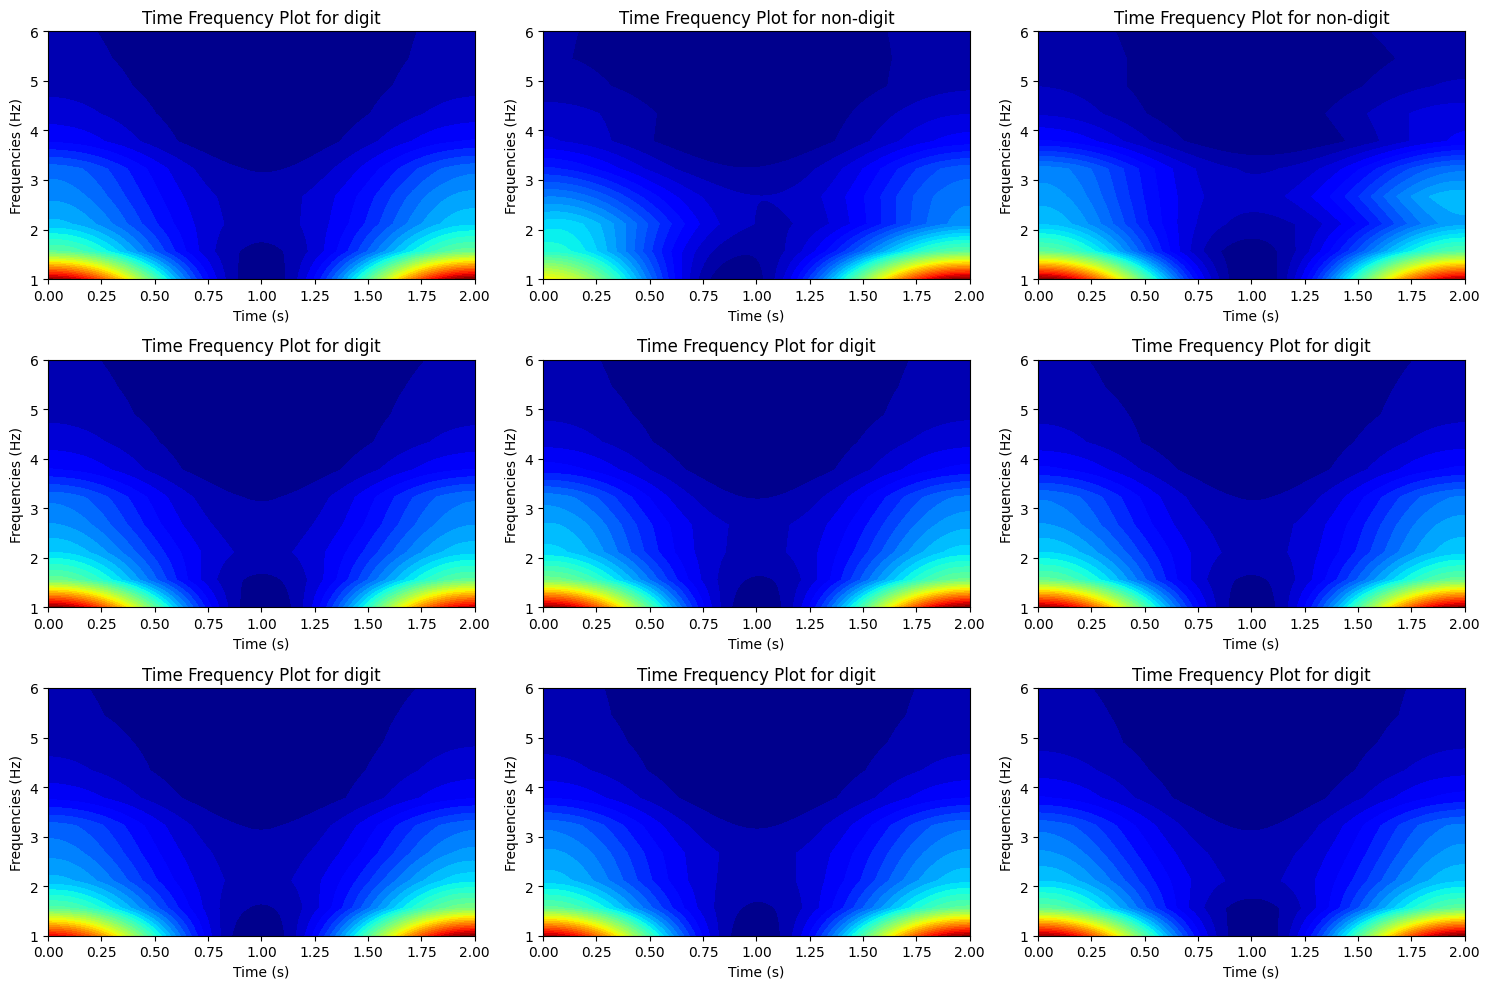

In [18]:
starting_freq = 1
end_freq = 6
num_frequencies = 10

#  Creates an array of time values starting from 0 to 2 seconds, with a total number of elements defined by median_length.
times = np.linspace(0,2,target_length)

nData = data_array.shape[1]
cmwX, nKern, frex = get_cmwX(nData, freqrange=[starting_freq, end_freq], numfrex=num_frequencies)
tf = time_frequency(data_array, cmwX, nKern)

fig, axs = plt.subplots(3, 3, figsize=(15, 10))

for i,ax in enumerate(axs.flat):
  x = random.randint(0, tf.shape[0])
  contour = ax.contourf(times, frex, tf[x,:,:], 40, cmap='jet')
  ax.set_xlabel('Time (s)')
  ax.set_ylabel('Frequencies (Hz)')
  ax.set_title(f"Time Frequency Plot for {'non-digit' if codes[x] == -1 else 'digit'}")

fig.tight_layout()